File to analyse our various results. 

In [5]:
# Packages needed for the script
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools


# matplotlib inline 
%matplotlib inline


In [57]:
# Set up plot style
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.figsize'] = (10, 6)

/var/folders/5n/dz64p0d10mbdprldq9m5sp08pnqwrk/T/ipykernel_86527/747729890.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
# Get the data
results_data = pd.read_csv('aggregated_results.csv')


Define a function to plot metric for each optimiser

In [55]:
def plot_optimizer_results(results_data, optimizer, metric='accuracy', metric_err='accuracy_std'):
    """
    Function to plot the results for a given optimizer.
    
    Parameters:
    - results_data: DataFrame containing the results data
    - optimizer: string, name of the optimizer to plot
    """
    # Filter the data for the specified optimizer
    optimizer_data = results_data[results_data['optimiser'] == optimizer]
    
    # Create custom x-axis labels with the combination of dropout and learning rate
    dropouts = [0.15, 0.2, 0.25]
    learning_rates = [0.0001, 0.0005, 0.005]
    combinations = list(itertools.product(learning_rates, dropouts))
    x_labels = [f"({a}, {b})" for a, b in combinations]
    
    # Marker and color styles for each line
    markers = ['o', 'D', '^']
    colours = ['blue', 'green', 'red']
    linestyles = ['-', '--', ':']
    Labels = ['CH training only', 
        'CH and final layer unfrozen', 
        'CH and final two layers unfrozen']
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Set the title -- comment out for plot for the paper
    #plt.title(f'{optimizer} Optimiser')
    
    # Set the x and y axis labels
    plt.xlabel('(Learning Rate, Dropout Rate)')
    if metric == 'accuracy':   
        plt.ylabel('Accuracy')
    elif metric == 'tn':
        plt.ylabel('True Negatives')
    elif metric == 'tp':
        plt.ylabel('True Positives')
    elif metric == 'f1_score':
        plt.ylabel('F1 Score')
    elif metric == 'total_train_time_s':
        plt.ylabel('Total Train Time (s)')
    else:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'tn', 'tp', or 'f1_score'.")
    
    # Set the x axis ticks
    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45)
    
    # Set the y axis ticks
    if metric == 'total_train_time_s': 
        plt.yticks(ticks=np.arange(0, 1001, 100))
    else:
        plt.yticks(ticks=np.arange(0, 1.1, 0.1))
    
    # Loop through the unique folder_lr values  
    for uf in optimizer_data['folder_unf'].unique():
        # Get the data for this number of layers unfrozen
        uf_data = optimizer_data[optimizer_data['folder_unf'] == uf]
        
        # Plot the data
        plt.errorbar(x_labels, uf_data[metric], yerr=uf_data[metric_err], 
                     marker=markers[int(uf)], color=colours[int(uf)], 
                     linestyle=linestyles[int(uf)], linewidth=4,
                     label=labels[int(uf)], capsize=5, elinewidth=4, 
                     markeredgewidth=1, markersize=8)
    
    plt.legend()
    
    # Save the plot
    plt.savefig(f'{optimizer}_optimiser_{metric}.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()



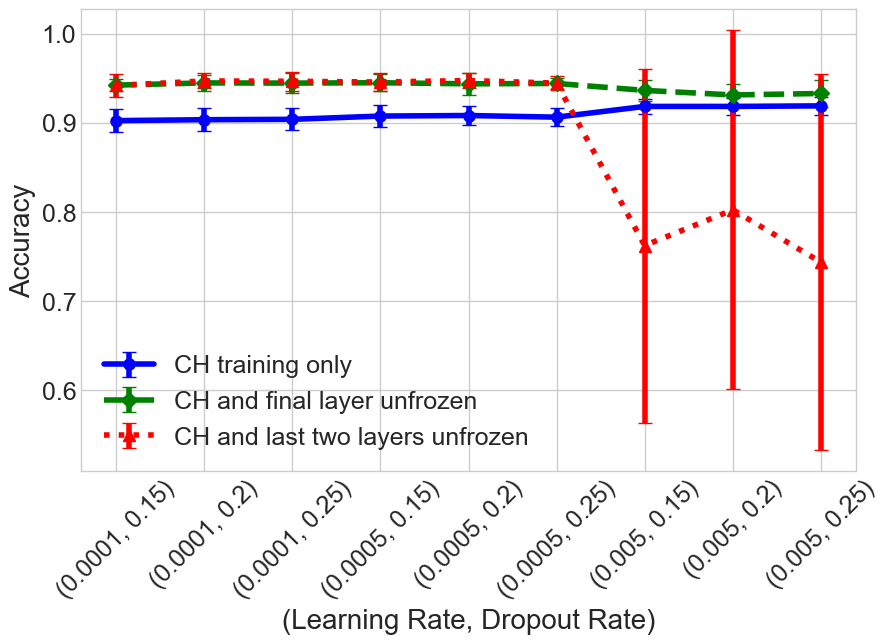

In [58]:
# Accuracy plot
plot_optimizer_results(results_data, 'AdamW', metric='accuracy', metric_err='accuracy_std')

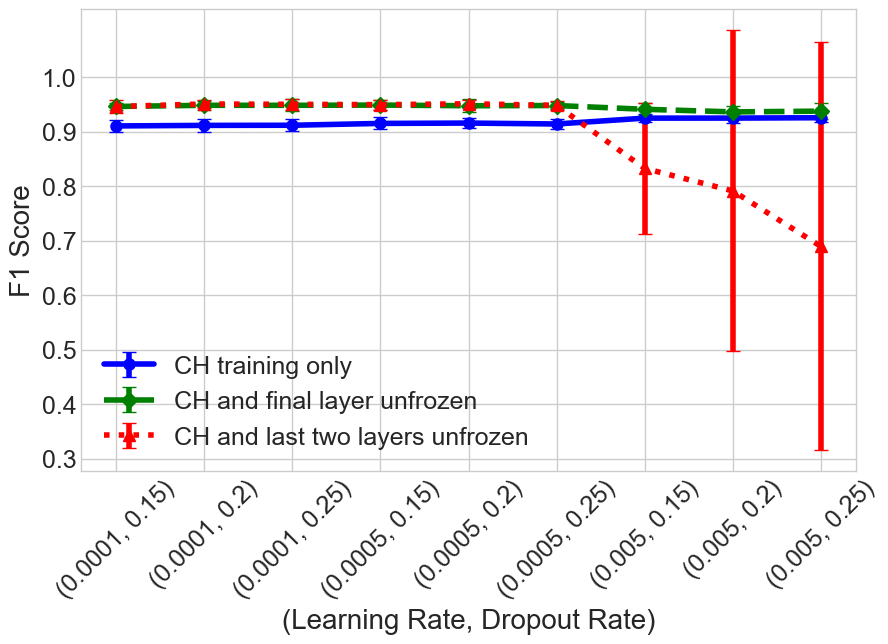

In [59]:
# F1 Score plot
plot_optimizer_results(results_data, 'AdamW', metric='f1_score', metric_err='f1_score_std')

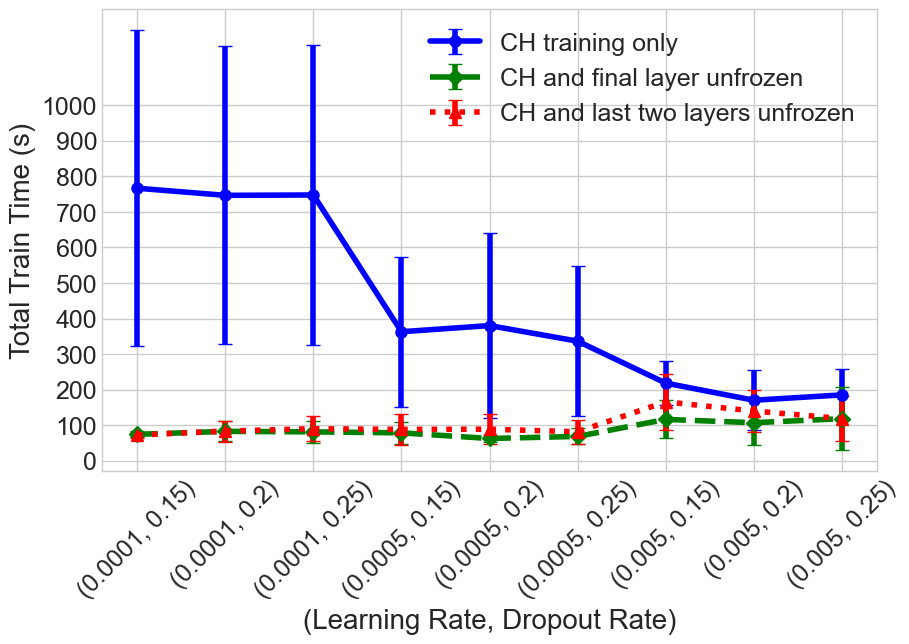

In [60]:
# Training time plot
plot_optimizer_results(results_data, 'AdamW', metric='total_train_time_s', metric_err='total_train_time_s_std')

Generate a table of the top results for the paper, we'll just use the learning rates of 0.0001 and 0.0005, and the 3 dropout rates. For just CH + 2 unfrozen layers, for each optimizer. 

In [ ]:
metricTable = 'accuracy'  # Change this to 'accuracy', 'f1_score' or 'total_train_time_s' as needed
# If loop to map metricTable to the correct metric in the results_data
if metricTable == 'accuracy':
    metric = 'accuracy'
    metric_err = 'accuracy_std'
elif metricTable == 'f1_score':
    metric = 'f1_score'
    metric_err = 'f1_score_std'
elif metricTable == 'total_train_time_s':
    metric = 'total_train_time_s'
    metric_err = 'total_train_time_s_std'
else:
    raise ValueError("Invalid metric. Choose from 'accuracy', 'f1_score', or 'total_train_time_s'.")

dropouts = [0.15, 0.2, 0.25]
learning_rates = [0.0001, 0.0005]
combinations = list(itertools.product(learning_rates, dropouts))
columns = [f"({a}, {b})" for a, b in combinations]

# LaTeX table header
header = "Optimiser & " + " & ".join(columns) + " \\\\ \\midrule"

# Put the results into the LaTeX table format
rows = []
for optimizer in results_data['optimiser'].unique():
    row = [optimizer]
    #optimizer_data = results_data[results_data['optimiser'] == optimizer]
    for a, b in combinations:
        match = results_data[
            (results_data['optimiser'] == optimizer) & 
            (results_data['folder_lr'] == a) & 
            (results_data['folder_dropout'] == b) & 
            (results_data['folder_unf'] == 2)
        ]
        if not match.empty: 
            mean = match[metric].values[0]
            std = match[metric_err].values[0]
            value = f"${mean:.3f} \\pm {std:.3f}$"
        else:
            value = "--"
        row.append(value)
    rows.append(" & ".join(row) + " \\\\")

# Put the LaTeX table together
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{l" + "c" * len(columns) + "}\n"
latex_table += "\\toprule\n" + header + "\n"
latex_table += "\n".join(rows) + "\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\caption{}\n\\label{tab:}\n\\end{table}"

# Print the LaTeX table
print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcccccc}
\toprule
Optimiser & (0.0001, 0.15) & (0.0001, 0.2) & (0.0001, 0.25) & (0.0005, 0.15) & (0.0005, 0.2) & (0.0005, 0.25) \\ \midrule
Adam & $163.105 \pm 101.368$ & $154.120 \pm 59.122$ & $146.162 \pm 47.057$ & $116.553 \pm 44.307$ & $135.623 \pm 56.608$ & $164.541 \pm 80.720$ \\
AdamW & $72.154 \pm 8.057$ & $83.473 \pm 29.602$ & $90.065 \pm 34.684$ & $88.163 \pm 44.063$ & $88.752 \pm 42.013$ & $81.651 \pm 33.359$ \\
SGD & $1493.626 \pm 605.140$ & $1494.104 \pm 604.769$ & $1414.752 \pm 600.150$ & -- & -- & -- \\
\bottomrule
\end{tabular}
\caption{}
\label{tab:}
\end{table}
